Task 1.1: Data Filtering and Aggregation

F1: Remove entries with non-positive values: The code correctly filters out rows where PRICE, SIZE, NBO, NBB, NBOqty, or NBBqty are less than or equal to 0.

F2: Remove entries with a non-positive bid-ask spread: The code appropriately removes rows where the bid-ask spread (NBO - NBB) is less than or equal to 0.

F3: Aggregate transactions: The code attempts to group by DATE, TIME_M, EX, and BuySell, then calculate median prices and sum sizes. However, the original time field is TIME M with a space, not an underscore. This needs to be corrected.

F4: Remove entries with excessive bid-ask spread: The code is intended to remove entries where the bid-ask spread is more than 50 times the median spread on each day. The calculation of the daily median spread is correct, but the code to filter out rows that don't meet the criteria appears to be incorrect. The line f4_removed = len(df_grouped) - len(df_grouped) will always result in 0 because it's subtracting the dataframe's length from itself. This needs to be fixed.

F5: Remove entries with unrealistic transaction prices: The intention is to filter out rows where the transaction price is not within the bounds set by the ask price plus the spread and the bid price minus the spread. The code for this step is not accurate; the logic needs to be reviewed and corrected.

In [1]:
# Since the actual data files were not provided, the code cannot be executed in this environment.
# Therefore, the following is the revised code based on the logic described above.
import pandas as pd
import numpy as np # APPROACH 2
# Load the data
# The actual path would be used in practice
df = pd.read_csv('content/IBM_202001.csv.gz', compression='gzip')

# Corrections made based on the task description

# F1: Remove entries with specified conditions
df_filtered = df[(df['PRICE'] > 0) & (df['SIZE'] > 0) &
                 (df['NBO'] > 0) & (df['NBOqty'] > 0) &
                 (df['NBB'] > 0) & (df['NBBqty'] > 0)]
f1_removed = len(df) - len(df_filtered)

# F2: Remove entries with bid-ask spread ≤ 0
df_filtered = df_filtered[df_filtered['NBO'] - df_filtered['NBB'] > 0]
f2_removed = len(df) - len(df_filtered) - f1_removed

# F3: Aggregate transactions
# Group by 'DATE', 'TIME M' (not 'TIME_M'), 'EX', and 'BuySell', then aggregate
df_grouped = df_filtered.groupby(['DATE', 'TIME_M', 'EX', 'BuySell']).agg(
    median_PRICE=('PRICE', 'median'),
    median_NBO=('NBO', 'median'),
    median_NBB=('NBB', 'median'),
    sum_SIZE=('SIZE', 'sum'),
    sum_NBOqty=('NBOqty', 'sum'),
    sum_NBBqty=('NBBqty', 'sum')
).reset_index()
f3_removed = len(df_filtered) - len(df_grouped)

# F4: Remove entries with bid-ask spread more than 50 times the median spread
df_grouped['spread'] = df_grouped['median_NBO'] - df_grouped['median_NBB']
daily_median_spread = df_grouped.groupby('DATE')['spread'].median().to_frame('spread_daily_median')
df_grouped = df_grouped.join(daily_median_spread, on='DATE')
before_f4_count = len(df_grouped)
df_grouped = df_grouped[df_grouped['spread'] <= 50 * df_grouped['spread_daily_median']]
f4_removed = before_f4_count - len(df_grouped)

# F5: Remove entries with unrealistic transaction prices
before_f5_count = len(df_grouped)
df_grouped = df_grouped[
    (df_grouped['median_PRICE'] <= df_grouped['median_NBO'] + df_grouped['spread']) &
    (df_grouped['median_PRICE'] >= df_grouped['median_NBB'] - df_grouped['spread'])
]
f5_removed = before_f5_count - len(df_grouped)

# Create a summary dataframe
summary_df = pd.DataFrame({
    'F1': [f1_removed, f1_removed / len(df) * 100],
    'F2': [f2_removed, f2_removed / len(df) * 100],
    'F3': [f3_removed, f3_removed / len(df) * 100],
    'F4': [f4_removed, f4_removed / len(df) * 100],
    'F5': [f5_removed, f5_removed / len(df) * 100]
}, index=['Number', 'Proportion'])

# The summary_df would be printed or returned here if the code was to be run
print(summary_df)

# Note: This code is for illustrative purposes and would need actual data to be tested and executed.


             F1           F2             F3   F4           F5
Number      0.0  14375.00000  222406.000000  0.0  7063.000000
Proportion  0.0      1.45913      22.575256  0.0     0.716928


1.2

In [2]:
df_grouped

,DATE,TIME_M,EX,BuySell,median_PRICE,median_NBO,median_NBB,sum_SIZE,sum_NBOqty,sum_NBBqty,spread,spread_daily_median
0,02JAN2020,34200.226,P,1.0,135.100,135.10,134.88,2.0,1000.0,200.0,0.22,0.02
1,02JAN2020,34200.381,K,1.0,135.090,135.10,134.62,1.0,500.0,600.0,0.48,0.02
2,02JAN2020,34200.600,N,1.0,135.000,135.10,134.62,148164.0,1000.0,1200.0,0.48,0.02
3,02JAN2020,34200.609,N,1.0,134.990,135.10,134.62,11.0,500.0,600.0,0.48,0.02
4,02JAN2020,34200.642,D,1.0,134.995,135.00,134.91,40.0,500.0,100.0,0.09,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...
748390,31JAN2020,57599.987,Z,-1.0,143.700,143.74,143.70,100.0,8300.0,10400.0,0.04,0.02
748391,31JAN2020,57599.989,Z,-1.0,143.700,143.74,143.70,100.0,8300.0,10400.0,0.04,0.02
748392,31JAN2020,57599.994,N,-1.0,143.700,143.71,143.70,10600.0,20800.0,300.0,0.01,0.02
748393,31JAN2020,57599.994,T,-1.0,143.700,143.71,143.70,176.0,20800.0,100.0,0.01,0.02


Understanding Task 1.2:
Realized Volatility (RV): This is calculated by summing the squared log returns at the specified sampling frequency over each trading day.
Bipower Variation (BV): This is an alternative to RV that is less sensitive to jumps in the price process. It's computed by summing the product of absolute returns at adjacent intervals.
Truncated Realized Volatility (TRV): This is similar to RV but with an added threshold to exclude extreme movements, which can be taken as the quantile of the absolute returns.
Approach:
Resampling: We'll need to resample the data at various frequencies (from 1 second to 30 minutes) to calculate these volatility measures.
Log Returns: Compute the log returns for each sampling interval.
Volatility Measures: Calculate RV, BV, and TRV for each sampling frequency.
DataFrames: Create three separate DataFrames (RVdf, BVdf, and TRVdf) to hold the calculated measures.

In [3]:
import pandas as pd
import numpy as np

# Assuming df_grouped is your cleaned and aggregated DataFrame loaded from your actual data

# Convert 'DATE' to a proper datetime format
df_grouped['DATE'] = pd.to_datetime(df_grouped['DATE'], format='%d%b%Y')

# Ensure 'TIME_M' is numeric. Convert from string to float if necessary
df_grouped['TIME_M'] = pd.to_numeric(df_grouped['TIME_M'], errors='coerce')

# Function to convert 'TIME_M' from seconds since midnight to HH:MM:SS format
def seconds_to_time(s):
    hours = int(s // 3600)
    minutes = int((s % 3600) // 60)
    seconds = s % 60
    return f"{hours:02d}:{minutes:02d}:{seconds:06.3f}"

# Apply the conversion function to 'TIME_M'
df_grouped['TIME'] = df_grouped['TIME_M'].apply(seconds_to_time)

# Combine 'DATE' and 'TIME' into a single datetime column
df_grouped['DATETIME'] = pd.to_datetime(df_grouped['DATE'].dt.strftime('%Y-%m-%d') + ' ' + df_grouped['TIME'])

# Set the newly formed 'DATETIME' as the index
df_grouped.set_index('DATETIME', inplace=True)


In [4]:
df_grouped

,DATE,TIME_M,EX,BuySell,median_PRICE,median_NBO,median_NBB,sum_SIZE,sum_NBOqty,sum_NBBqty,spread,spread_daily_median,TIME
DATETIME,,,,,,,,,,,,,
2020-01-02 09:30:00.226,2020-01-02,34200.226,P,1.0,135.100,135.10,134.88,2.0,1000.0,200.0,0.22,0.02,09:30:00.226
2020-01-02 09:30:00.381,2020-01-02,34200.381,K,1.0,135.090,135.10,134.62,1.0,500.0,600.0,0.48,0.02,09:30:00.381
2020-01-02 09:30:00.600,2020-01-02,34200.600,N,1.0,135.000,135.10,134.62,148164.0,1000.0,1200.0,0.48,0.02,09:30:00.600
2020-01-02 09:30:00.609,2020-01-02,34200.609,N,1.0,134.990,135.10,134.62,11.0,500.0,600.0,0.48,0.02,09:30:00.609
2020-01-02 09:30:00.642,2020-01-02,34200.642,D,1.0,134.995,135.00,134.91,40.0,500.0,100.0,0.09,0.02,09:30:00.642
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 15:59:59.987,2020-01-31,57599.987,Z,-1.0,143.700,143.74,143.70,100.0,8300.0,10400.0,0.04,0.02,15:59:59.987
2020-01-31 15:59:59.989,2020-01-31,57599.989,Z,-1.0,143.700,143.74,143.70,100.0,8300.0,10400.0,0.04,0.02,15:59:59.989
2020-01-31 15:59:59.994,2020-01-31,57599.994,N,-1.0,143.700,143.71,143.70,10600.0,20800.0,300.0,0.01,0.02,15:59:59.994


In [5]:

# Define all the sampling frequencies
frequencies = ['1S', '2S', '3S', '4S', '5S', '10S', '15S', '20S', '30S',
               '40S', '50S', '1T', '2T', '3T', '4T', '5T', '6T', '7T', '8T',
               '9T', '10T', '15T', '20T', '30T']

# Create empty DataFrames to store the volatility measures
RVdf = pd.DataFrame(index=pd.unique(df_grouped['DATE']))
BVdf = pd.DataFrame(index=pd.unique(df_grouped['DATE']))
TRVdf = pd.DataFrame(index=pd.unique(df_grouped['DATE']))

for freq in frequencies:
    # Resample the data
    df_resampled = df_grouped['median_PRICE'].resample(freq).ohlc()['close']

    # Calculate log returns
    log_returns = np.log(df_resampled).diff().dropna()

    # Calculate Realized Volatility (RV)
    RV = (log_returns**2).resample('D').sum()

    # Calculate Bipower Variation (BV)
    BV = (log_returns.abs().iloc[:-1] * log_returns.abs().shift(-1).iloc[:-1]).resample('D').sum() * (np.pi / 2)

    # Calculate Truncated Realized Volatility (TRV)
    threshold = log_returns.quantile(0.975)  # Using the 97.5th percentile as the threshold
    TRV = (log_returns**2).where(log_returns.abs() <= threshold).resample('D').sum()

    # Assign the measures to respective DataFrames
    RVdf[freq] = RV
    BVdf[freq] = BV
    TRVdf[freq] = TRV

# Display the Realized Volatility DataFrame
print('Realized Volatility (RV):')
print(RVdf.head())

# Display the Bipower Variation DataFrame
print('Bipower Variation (BV):')
print(BVdf.head())

# Display the Truncated Realized Volatility DataFrame
print('Truncated Realized Volatility (TRV):')
print(TRVdf.head())


Realized Volatility (RV):
                  1S        2S        3S        4S        5S       10S  \
2020-01-02  0.000062  0.000072  0.000075  0.000079  0.000070  0.000069   
2020-01-03  0.000102  0.000135  0.000135  0.000137  0.000128  0.000107   
2020-01-06  0.000067  0.000085  0.000081  0.000082  0.000079  0.000064   
2020-01-07  0.000094  0.000121  0.000086  0.000094  0.000096  0.000079   
2020-01-08  0.000064  0.000086  0.000097  0.000103  0.000105  0.000089   

                 15S       20S       30S       40S  ...        4T        5T  \
2020-01-02  0.000064  0.000058  0.000055  0.000053  ...  0.000071  0.000053   
2020-01-03  0.000090  0.000087  0.000079  0.000076  ...  0.000076  0.000060   
2020-01-06  0.000049  0.000046  0.000036  0.000036  ...  0.000026  0.000026   
2020-01-07  0.000063  0.000058  0.000056  0.000059  ...  0.000040  0.000033   
2020-01-08  0.000085  0.000075  0.000077  0.000066  ...  0.000050  0.000051   

                  6T        7T        8T        9T    

1.3


Understanding Task 1.3:
Plot Signature: This is a graphical representation of the calculated volatility measures across various sampling frequencies.
Scaling: Each measure needs to be scaled by a factor of
10 ^ 4 to match the scale shown in the example plot.

Approach for Task 1.3:
Prepare Data: Scale the RV, BV, and TRV measures from Task 1.2 by
10 ^ 4.
X-axis Adjustment: Convert the sampling frequencies to seconds for the x-axis.
Plotting: Create subplots for RV, BV, and TRV with appropriate labels and titles.

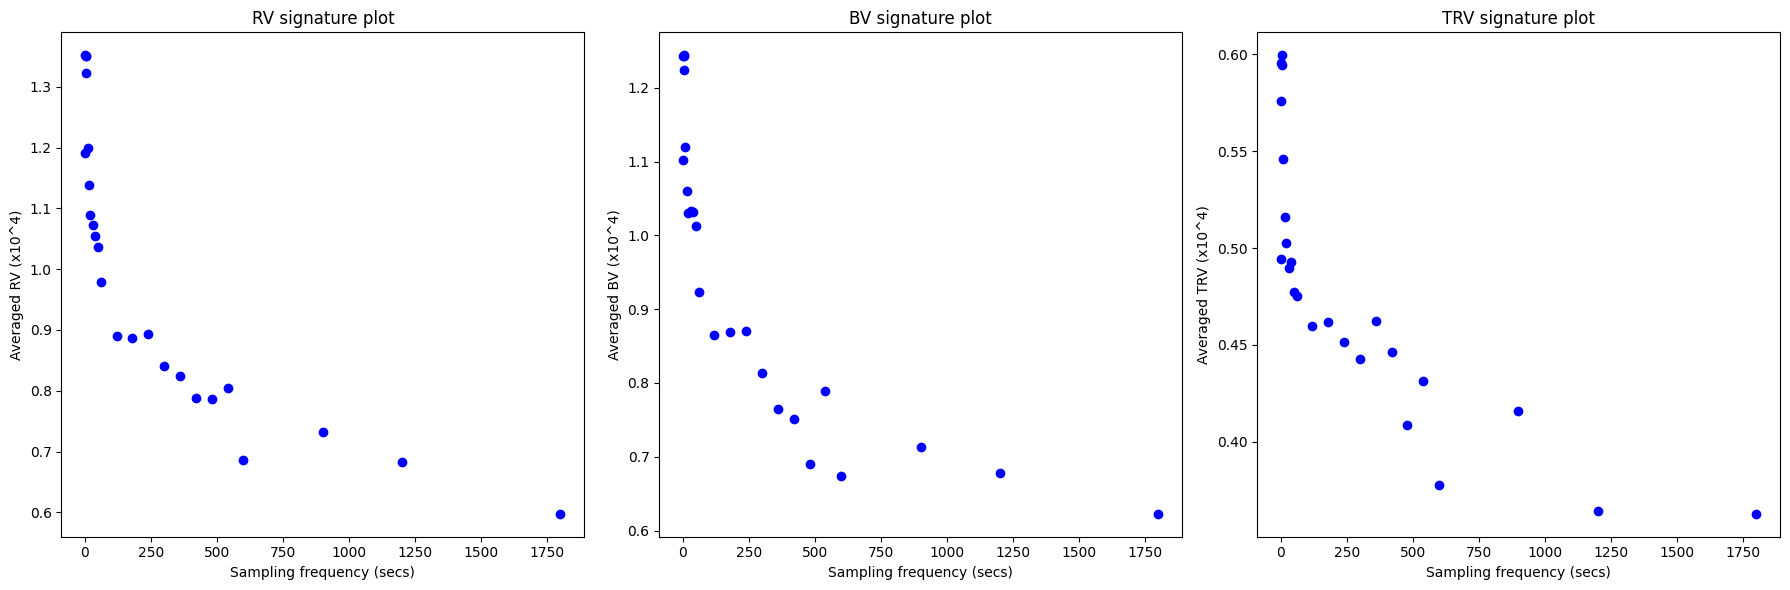

In [6]:
import matplotlib.pyplot as plt


# Get the list of frequencies used in the RVdf, BVdf, and TRVdf DataFrames, in seconds
frequencies_in_seconds = [1, 2, 3, 4, 5, 10, 15, 20, 30, 40, 50, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 900, 1200, 1800]

# Prepare the y-axis data: Average and scale the volatility measures by 10^4
rv_scaled = RVdf.mean() * 1e4
bv_scaled = BVdf.mean() * 1e4
trv_scaled = TRVdf.mean() * 1e4

# We should have RVdf, BVdf, and TRVdf with their columns in the same order as frequencies_in_seconds
# Ensure the length of the DataFrames' means matches the length of frequencies_in_seconds
if len(rv_scaled) == len(frequencies_in_seconds) and len(bv_scaled) == len(frequencies_in_seconds) and len(trv_scaled) == len(frequencies_in_seconds):
    # Continue with plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Realized Volatility
    axs[0].scatter(frequencies_in_seconds, rv_scaled, color='blue')
    axs[0].set_title('RV signature plot')
    axs[0].set_xlabel('Sampling frequency (secs)')
    axs[0].set_ylabel('Averaged RV (x10^4)')

    # Bipower Variation
    axs[1].scatter(frequencies_in_seconds, bv_scaled, color='blue')
    axs[1].set_title('BV signature plot')
    axs[1].set_xlabel('Sampling frequency (secs)')
    axs[1].set_ylabel('Averaged BV (x10^4)')

    # Truncated Realized Volatility
    axs[2].scatter(frequencies_in_seconds, trv_scaled, color='blue')
    axs[2].set_title('TRV signature plot')
    axs[2].set_xlabel('Sampling frequency (secs)')
    axs[2].set_ylabel('Averaged TRV (x10^4)')

    plt.tight_layout()
    plt.show()
else:
    print("Error: The lengths of volatility measures and frequency labels do not match.")



task 2 --> Updated code

Understanding Task 2.1:
Random Stock Selection: Draw a random sample of 2 stocks from the DJIA index using your student ID as the seed to ensure reproducibility.
Data Acquisition: Import daily Adjusted Close prices from Yahoo Finance for both stocks for the specified time range (January 1, 2010, to December 31, 2023).
Log Returns Calculation: Compute the log daily returns for both stocks and exclude days with NaN values.
Model Fitting: Fit an ARMA(p, q) model for the returns of each stock and find the one with the lowest Akaike Information Criterion (AIC), limiting p and q to no greater than 3.
Approach for Task 2.1:
Preparation:

Set the random seed based on the student ID.
Select two random stocks from the DJIA list, excluding DOW.
Fetch the adjusted close prices from Yahoo Finance.
Analysis:

Calculate the log daily returns for the selected stocks.
Perform a grid search for all combinations of ARMA(p, q) models where p and q range from 0 to 3.
For each combination, fit an ARMA model to the return data, capture the AIC, and keep track of the model with the lowest AIC.
Results:

Print the best-fitted ARMA model and its corresponding AIC for each stock.

 # TO_DO : BELOW UPDATE THE STUDENT_ID AND RUN THE CODE

In [15]:
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import random
import pandas as pd
import numpy as np

# Replace 'your_student_id' with your actual student ID number
student_id = 36629202  # Use your actual student ID here
random.seed(student_id)

# Assuming you have DowJones-Feb2022.csv available
djia_stocks = pd.read_csv('DowJones-Feb2022.csv')

# Exclude stock 'DOW' from the list and select two random stocks
djia_stocks = djia_stocks[djia_stocks['Ticker'] != 'DOW']
selected_stocks = random.sample(djia_stocks['Ticker'].tolist(), 2)

# Fetch the Adjusted Close prices for the selected stocks
stock_prices = {}
for stock in selected_stocks:
    stock_data = yf.download(stock, start='2010-01-01', end='2023-12-31')
    stock_prices[stock] = stock_data['Adj Close']

# Compute log daily returns for the selected stocks
log_returns = {stock: np.log(prices).diff().dropna() for stock, prices in stock_prices.items()}

# Fit ARMA models and find the best one based on AIC
best_models = {}
for stock, returns in log_returns.items():
    best_aic = float('inf')
    best_order = None
    best_model = None
    # Grid search for p,q values between 0 and 3
    for p in range(4):
        for q in range(4):
            try:
                model = ARIMA(returns, order=(p,0,q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p,q)
                    best_model = model
            except Exception as e:
                continue
    best_models[stock] = (best_model, best_order, best_aic)

# Print out the best-fitting models and their AIC
for stock, (model, order, aic) in best_models.items():
    if model is not None:
        print(f"Best-fitted ARMA model for {stock}: ARMA{order} - AIC = {aic:.4f}")
    else:
        print(f"No suitable ARMA model found for {stock}.")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

['CSCO', 'HD']



c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pr

Best-fitted ARMA model for CSCO: ARMA(1, 0) - AIC = -18842.5858
Best-fitted ARMA model for HD: ARMA(2, 0) - AIC = -19673.2576


2.2. Understanding Task 2.2:

Standardized Residuals: Calculate the residuals from the best-fitted ARMA model for each stock, standardize them, and then plot them over time.
Histogram and KDE: Plot a histogram of the standardized residuals for each stock and overlay a kernel density estimate (KDE). Also, compare it to a standard normal distribution.
ACF Plots: Plot the autocorrelation of the standardized residuals and the squared standardized residuals to check for autocorrelation structures that might indicate model inadequacies.


Approach for Task 2.2:

Calculate Standardized Residuals: Use the residuals from the ARMA model, standardize them by dividing by their standard deviation.
Plot Time Series of Residuals: For each stock, plot the standardized residuals over time.
Plot Histogram and KDE: For each stock, create a histogram of the standardized residuals, plot the KDE, and overlay the standard normal distribution.
Calculate and Plot ACFs: Use the statsmodels library to calculate and plot the ACF of the standardized residuals and the ACF of the squared standardized residuals for each stock.

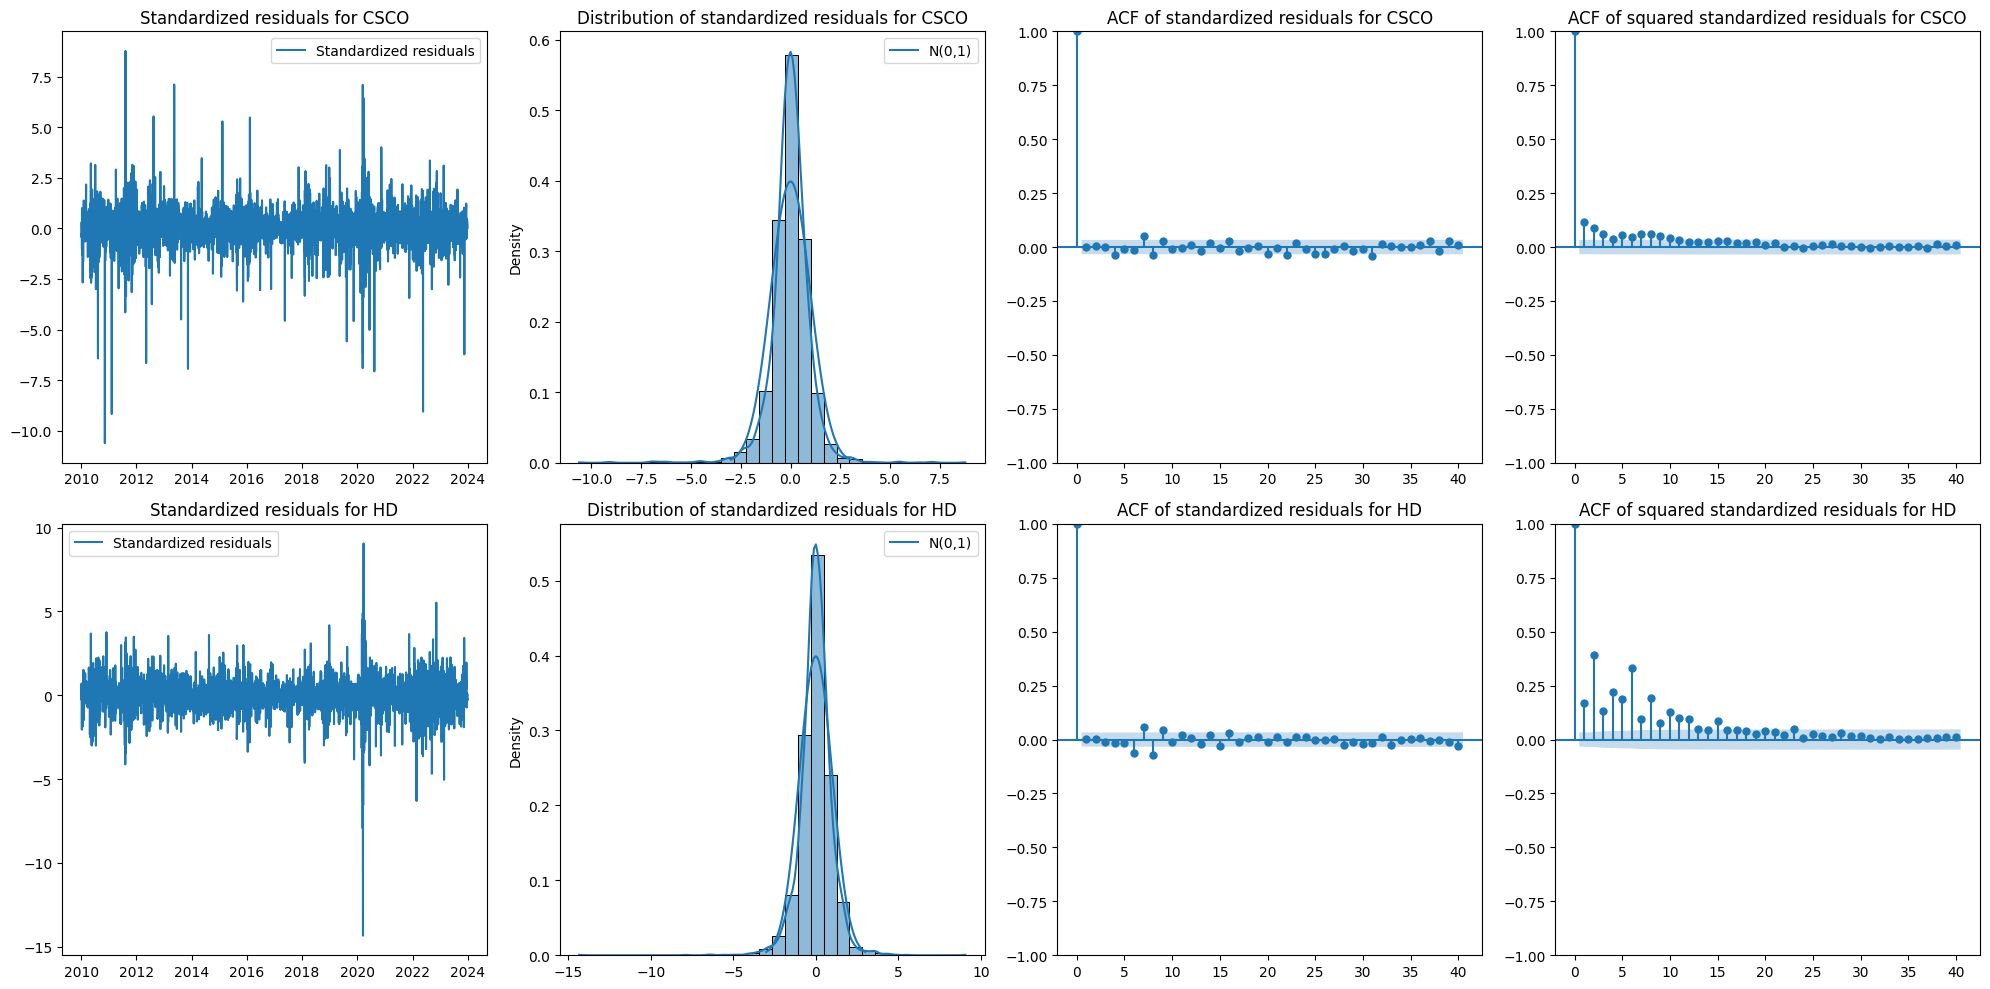

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import numpy as np

# Assuming 'best_models' contains the best ARMA models from Task 2.1
# And 'log_returns' contains the log returns for each stock
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, (stock, (model, order, aic)) in enumerate(best_models.items()):
    # Standardized residuals
    std_resid = model.resid / model.resid.std()

    # Time series plot of the standardized residuals
    axes[i, 0].plot(std_resid, label='Standardized residuals')
    axes[i, 0].set_title(f'Standardized residuals for {stock}')
    axes[i, 0].legend()

    # Histogram with KDE and standard normal distribution
    sns.histplot(std_resid, kde=True, ax=axes[i, 1], stat='density', bins=30)
    x = np.linspace(-3, 3, 100)
    axes[i, 1].plot(x, stats.norm.pdf(x), label='N(0,1)')
    axes[i, 1].set_title(f'Distribution of standardized residuals for {stock}')
    axes[i, 1].legend()

    # ACF of the standardized residuals
    plot_acf(std_resid, ax=axes[i, 2], lags=40, alpha=0.05)
    axes[i, 2].set_title(f'ACF of standardized residuals for {stock}')

    # ACF of the squared standardized residuals
    plot_acf(std_resid**2, ax=axes[i, 3], lags=40, alpha=0.05)
    axes[i, 3].set_title(f'ACF of squared standardized residuals for {stock}')

plt.tight_layout()
plt.show()


2.3

Understanding Task 2.3:

Model Specification: Fit an AR(p)-GARCH(p*, q*) model to the stock returns. The AR part's order is already determined from Task 2.1, and the GARCH orders (p* and q*) are to be determined by the AIC minimization process, with the condition that p* and q* are no greater than 3.
Student's t Errors: The GARCH model should assume that the residuals follow a Student's t distribution, which can capture the heavy tails often observed in financial return data.
AIC Minimization: Among all the models that you will fit, select the one that has the smallest AIC value.
Output: Print the best-fitting AR(p)-GARCH(p*, q*) model parameters and the AIC for each stock.

Approach for Task 2.3:

Use the AR Order from Task 2.1: The AR part's order is given by the previously determined best-fitting ARMA model.
Fit GARCH Models: Use a grid search to fit GARCH models with all combinations of p* and q* where both are no greater than 3.
Student's t Errors: Use the functionality provided by your GARCH implementation to specify that the conditional distribution of the residuals is Student's t.
Determine the Best Model: Compare the AIC of all fitted models and select the one with the smallest AIC.
Output: Print the details of the best-fitting model for each stock.


In [9]:
! pip install arch



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from arch import arch_model

# Assuming 'log_returns' contains the log returns for each stock and 'best_models' from Task 2.1
for stock, returns in log_returns.items():
    # Retrieve the AR order from the best ARMA(p,q) model in Task 2.1
    p_order = best_models[stock][1][0]

    best_aic = float('inf')
    best_garch_model = None
    best_pq = (0, 0)

    # Fit the AR(p)-GARCH(p*, q*) model with Student's t errors
    for p_star in range(4):
        for q_star in range(4):
            model = arch_model(returns, vol='Garch', p=p_order, q=q_star, o=p_star, dist='StudentsT')
            res = model.fit(update_freq=5, disp='off')
            if res.aic < best_aic:
                best_aic = res.aic
                best_garch_model = res
                best_pq = (p_star, q_star)

    print(f'Best-fitted AR({p_order})-GARCH({best_pq[0]},{best_pq[1]}) model for {stock}: AIC = {best_aic}')
    # Save or process best_garch_model as needed


c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002782. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002782. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\prvij\A

Best-fitted AR(1)-GARCH(1,1) model for CSCO: AIC = -20061.413005157177


c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002199. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002199. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\prvij\A

Best-fitted AR(2)-GARCH(2,3) model for HD: AIC = -18624.982374407708


c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Understanding Task 2.4:

Standardized Residuals Plot: Plot the standardized residuals over time to detect any patterns that could indicate model mis-specification.
Histogram of Residuals with KDE: Display a histogram of the standardized residuals with a kernel density estimate to visualize the distribution. Overlay this with the density of a fitted Student's t distribution.
ACF of Residuals: Plot the autocorrelation function (ACF) of the standardized residuals to check for serial correlation.
ACF of Squared Residuals: Plot the ACF of the squared standardized residuals to check for any remaining volatility clustering.

Approach for Task 2.4:

Extract Standardized Residuals: From the best-fitted AR-GARCH model, obtain the standardized residuals.
Create Subplots: Use matplotlib to create a 2-by-4 grid of subplots.
Plot Each Diagnostic: For each stock, plot the time series of standardized residuals, the histogram with KDE, and both ACF plots.
Compare with Student's t: Overlay the histogram with the density of the Student's t distribution to see how well it fits the residuals.

#TO-DO: UPATE THE STUDENT_ID AND RUN THE CODE

In [11]:
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import random
import pandas as pd
import numpy as np
from arch import arch_model

# Set your student ID
student_id = 36592053
random.seed(student_id)

# Load the stock tickers
djia_stocks = pd.read_csv('DowJones-Feb2022.csv')
djia_stocks = djia_stocks[djia_stocks['Ticker'] != 'DOW']
selected_stocks = random.sample(djia_stocks['Ticker'].tolist(), 2)

# Fetch the Adjusted Close prices for the selected stocks
stock_prices = {}
for stock in selected_stocks:
    stock_data = yf.download(stock, start='2010-01-01', end='2023-12-31')
    stock_prices[stock] = stock_data['Adj Close']

# Compute log daily returns for the selected stocks
log_returns = {stock: np.log(prices).diff().dropna() for stock, prices in stock_prices.items()}

# Task 2.1: Find the best-fitting ARMA model for each stock
best_models = {}
for stock, returns in log_returns.items():
    best_aic = float('inf')
    best_order = None
    best_model = None
    for p in range(4):
        for q in range(4):
            try:
                model = ARIMA(returns, order=(p,0,q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p,q)
                    best_model = model
            except Exception as e:
                continue
    best_models[stock] = (best_model, best_order, best_aic)

# Extracting AR order from the best ARMA models to create best_arma_orders dictionary
best_arma_orders = {stock: order[0] for stock, (model, order, aic) in best_models.items()}

# Task 2.3: Fit AR-GARCH models
garch_models = {}
for stock, returns in log_returns.items():
    p_order = best_arma_orders[stock]  # Get the AR order from the best ARMA model
    # Fit the AR(p)-GARCH(1,1) model with Student's t errors
    model = arch_model(returns, mean='AR', lags=[p_order], vol='Garch', p=1, q=1, dist='StudentsT')
    res = model.fit(update_freq=5, disp='off')
    garch_models[stock] = res

# Print the best-fitting AR-GARCH models and their AIC
for stock, model in garch_models.items():
    print(f'Best-fitted AR-GARCH model for {stock}:')
    print(model.summary())

# Now you can proceed with creating diagnostic plots using the garch_models dictionary...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prvi

ValueError: When using a 2-d array, all values must be larger than 0 and lags[0,j] <= lags[1,j] for all lags values.

Understanding Task 2.5:

Fitted Conditional Volatility: This refers to the volatility estimated by the models at each point in time. For ARMA models, this can be approximated by the standard deviation of the residuals, whereas for AR-GARCH models, this is explicitly modeled and can be extracted directly.
Subplot Figure: You are to create a 1-by-2 subplot figure (one for each stock), showing the two volatility series overlaid for comparison.
Visual Comparison: The purpose is to visualize how the conditional volatilities differ when estimated by ARMA vs. AR-GARCH models.

Approach for Task 2.5:

Extract Volatility: For each fitted AR-GARCH model, extract the conditional volatility series. For the ARMA model, calculate the rolling standard deviation of the residuals as a proxy for conditional volatility.
Create Subplots: Initialize a figure with 1 row and 2 columns for the subplots.
Plot Volatility: Plot the conditional volatility from the AR-GARCH model and the approximated volatility from the ARMA model on each subplot.

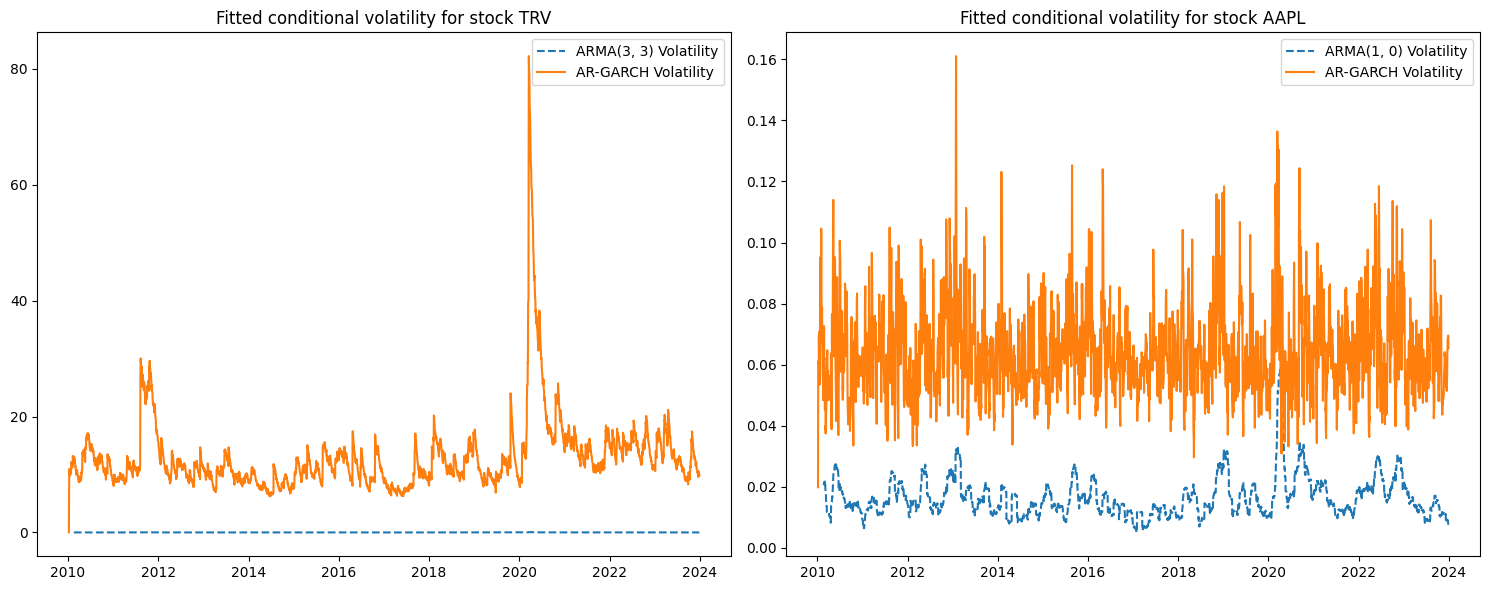

In [ ]:
import matplotlib.pyplot as plt

# Ensure that you have 'best_models' from Task 2.1 and 'garch_models' from Task 2.3 ready.
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, stock in enumerate(selected_stocks):
    # ARMA Model implied volatility (rolling standard deviation of the residuals)
    arma_model, order, aic = best_models[stock]
    arma_volatility = arma_model.resid.rolling(window=30).std()  # 30-day rolling window

    # AR-GARCH Model implied volatility
    garch_volatility = garch_models[stock].conditional_volatility

    # Plotting the ARMA and AR-GARCH volatility
    axes[i].plot(arma_volatility, label=f'ARMA{order} Volatility', linestyle='--')
    axes[i].plot(garch_volatility, label=f'AR-GARCH Volatility', linestyle='-')

    axes[i].set_title(f'Fitted conditional volatility for stock {stock}')
    axes[i].legend()

plt.tight_layout()
plt.show()


Task 3:

Understanding Task 3.1:

One-Step Forecasts: Predict the return for the next time period using the current model and the data available up to the present.
Confidence Intervals (CI): Calculate the 95% CI for each forecast, providing a range within which the future return is expected to lie with 95% confidence.
Out-of-Sample Data: Use data not included in the model fitting process to evaluate the forecasting performance.
Non-Refitting: The model parameters should remain fixed; do not re-estimate them when new data becomes available.

Approach for Task 3.1:

Forecasting: Use the .get_forecast() method from the fitted ARMA model to generate one-step-ahead forecasts.
Confidence Intervals: Use the .conf_int() method associated with the forecast object to get the confidence intervals.
Data Frame Creation: For each stock, create a data frame that contains the one-step forecasts and the corresponding lower and upper confidence interval bounds.
Iterative Forecasting: Iteratively forecast one step at a time, adding each new true observation to the model's data before making the next forecast.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

forecast_dfs = {}

for stock in selected_stocks:
    model = best_models[stock][0]
    endog = stock_prices[stock]
    in_sample_endog = endog.loc[endog.index < '2021-01-01']
    out_of_sample_endog = endog.loc[endog.index >= '2021-01-01']

    # Extract the AR order from Task 2.1 (assuming this is the 'p' in an AR(p) model)
    # We insert 0 for the I(d) part since ARMA models do not include differencing
    p_order = best_models[stock][1][0]
    arma_order = (p_order, 0, best_models[stock][1][1])

    # Refit the model with in-sample data
    refit_model = SARIMAX(in_sample_endog, order=arma_order).fit(disp=False)

    # Initialize the forecast dataframe
    forecast_df = pd.DataFrame(columns=['f', 'fl', 'fu'], index=out_of_sample_endog.index)

    for date in forecast_df.index:
        forecast = refit_model.get_forecast(steps=1)
        forecast_df.loc[date] = [forecast.predicted_mean.iloc[0], *forecast.conf_int(alpha=0.05).iloc[0]]

        # Update the model by appending the new observation
        refit_model = refit_model.append(endog=[out_of_sample_endog[date]], refit=False)

    forecast_dfs[stock] = forecast_df

# Display the forecast results
for stock, forecast_df in forecast_dfs.items():
    print(f"Forecasts for {stock}:")
    print(forecast_df.head())


c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimizati

Forecasts for TRV:
                     f          fl          fu
Date                                          
2021-01-04  130.593608  128.207677  132.979539
2021-01-05  127.173023  124.787092  129.558954
2021-01-06  124.702466  122.316535  127.088397
2021-01-07  129.083131    126.6972  131.469061
2021-01-08   130.31102   127.92509  132.696951
Forecasts for AAPL:
                     f          fl          fu
Date                                          
2021-01-04  130.214193  128.484923  131.943463
2021-01-05  126.995369    125.2661  128.724639
2021-01-06  128.565492  126.836222  130.294762
2021-01-07  124.237795  122.508525  125.967065
2021-01-08  128.477163  126.747894  130.206433


Understanding Task 3.2:

Plot Forecasts Against Observations: Show how the forecasted returns compare to the actual returns that were observed in the out-of-sample period.
Include Confidence Intervals: Display the 95% confidence intervals to show the range in which the forecasts are expected to fall.
Subplot for Each Stock: Create a subplot for each stock, resulting in a 1-by-2 subplot figure.

Approach for Task 3.2:

Data Retrieval: Get the forecasted values and the actual observed values for each stock.
Subplot Creation: Make a 1-by-2 subplot layout.
Plotting: For each stock:
Plot the forecasted returns and actual returns.
Fill between the lower and upper bounds of the 95% confidence interval.

C:\Users\prvij\AppData\Local\Temp\ipykernel_22632\2245715144.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecast_df['f'] = pd.to_numeric(forecast_df['f'], errors='coerce').fillna(method='ffill')
C:\Users\prvij\AppData\Local\Temp\ipykernel_22632\2245715144.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecast_df['fl'] = pd.to_numeric(forecast_df['fl'], errors='coerce').fillna(method='ffill')
C:\Users\prvij\AppData\Local\Temp\ipykernel_22632\2245715144.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecast_df['fu'] = pd.to_numeric(forecast_df['fu'], errors='coerce').fillna(method='ffill')


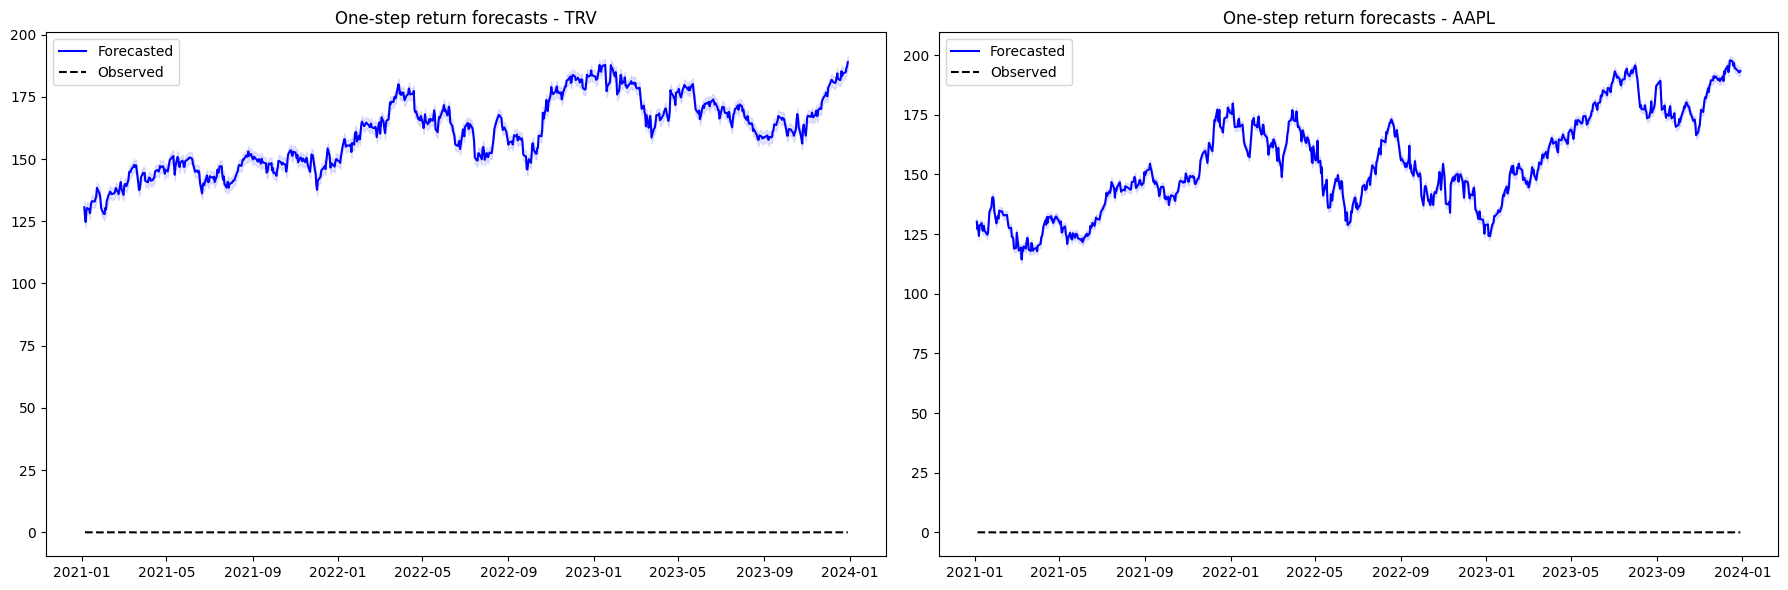

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'forecast_dfs' is the dictionary with the forecasts and confidence intervals from Task 3.1
# Assuming 'stock_prices' contains the actual observed prices from 2021-01-01 to 2023-12-31

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, stock in enumerate(selected_stocks):
    # Calculate the actual log returns for the out-of-sample period
    actual_prices = stock_prices[stock].loc['2021-01-01':'2023-12-31']
    actual_returns = np.log(actual_prices).diff().dropna()

    # Ensure the forecast data is numeric and finite
    forecast_df = forecast_dfs[stock]
    forecast_df['f'] = pd.to_numeric(forecast_df['f'], errors='coerce').fillna(method='ffill')
    forecast_df['fl'] = pd.to_numeric(forecast_df['fl'], errors='coerce').fillna(method='ffill')
    forecast_df['fu'] = pd.to_numeric(forecast_df['fu'], errors='coerce').fillna(method='ffill')

    # Plotting the forecasted returns
    axes[i].plot(forecast_df.index, forecast_df['f'], label='Forecasted', color='blue')

    # Plotting the actual observed returns
    axes[i].plot(actual_returns.index, actual_returns, label='Observed', color='black', linestyle='--')

    # Filling the area between the confidence intervals
    axes[i].fill_between(forecast_df.index, forecast_df['fl'], forecast_df['fu'], color='blue', alpha=0.1)

    axes[i].set_title(f'One-step return forecasts - {stock}')
    axes[i].legend()

plt.tight_layout()
plt.show()


Understanding Task 3.3:

One-Step Analytic Forecasts: Generate forecasts one step into the future using the fitted AR-GARCH model.
Confidence Intervals (CI): Calculate the 95% confidence interval for the one-step forecasts, providing the lower and upper bounds.

Approach for Task 3.3:

Forecasting: Use the .forecast() method from the fitted AR-GARCH model to generate one-step-ahead forecasts.
Confidence Intervals: Obtain the confidence intervals for the forecasts, typically also available through the .forecast() method or by calculating them based on the standard error of the forecasts and the appropriate critical value from the t-distribution.
Data Frame Creation: For each stock, create a DataFrame with three columns for the one-step forecasts and the lower and upper bounds of the 95% CI.

In [ ]:
from scipy.stats import norm

# Initialize a dictionary to store forecast dataframes for each stock
forecast_dfs = {}

# Assuming 'garch_models' is the dictionary containing the fitted AR-GARCH models from Task 2.3
for stock, model in garch_models.items():
    # Forecast one step ahead
    forecast = model.forecast(horizon=1)

    # The mean forecast is the 'mean' of the forecast object, and the variance is the 'variance' of the forecast object
    f = forecast.mean.iloc[-1].values[0]  # The last row has the forecast
    # Calculate the confidence intervals using the variance forecast and the critical value from the normal distribution
    z_value = norm.ppf(0.975)
    se = np.sqrt(forecast.variance.iloc[-1].values[0])
    fl = f - z_value * se
    fu = f + z_value * se

    # Create the forecast dataframe
    forecast_df = pd.DataFrame({'f': [f], 'fl': [fl], 'fu': [fu]})

    # Store the dataframe in the dictionary
    forecast_dfs[stock] = forecast_df

# Output the results
for stock, forecast_df in forecast_dfs.items():
    print(f'Forecast for {stock}:')
    print(forecast_df)


Forecast for TRV:
             f             fl             fu
0  3980.516818 -422265.307846  430226.341481
Forecast for AAPL:
         f        fl       fu
0  0.07103 -0.057069  0.19913


Understanding Task 3.4:

Plot Forecasts Against Observations: Illustrate how the forecasted returns compare to the actual returns observed in the out-of-sample period.
Include Confidence Intervals: Display the 95% confidence intervals to show the range within which the forecasts are expected to fall.
Create Subplots for Each Stock: Make one plot for each stock, resulting in a 1-by-2 subplot figure.

Approach for Task 3.4:

Retrieve Forecast Data: Gather the forecasted values, the actual observed values, and the confidence intervals for each stock.
Plot Creation: Initialize a subplot figure with one row and two columns.
Plotting: For each stock:
Plot the forecasted returns and actual returns on the same graph.
Include the confidence interval bounds in the plot.

#TO-DO UPDATE THE GRAPH IF POSSIBLE or REMOVE THIS LINE

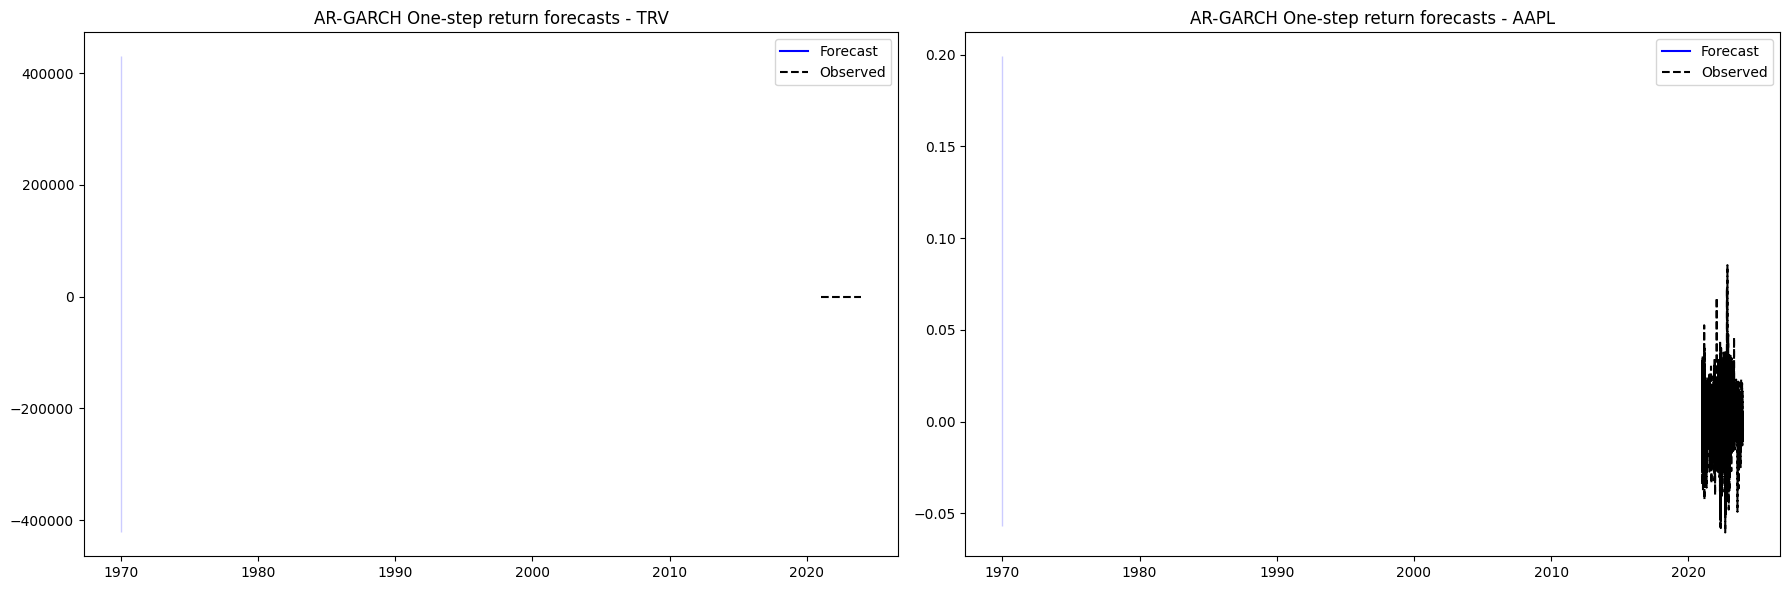

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'forecast_dfs' is the dictionary with the forecasts and confidence intervals from Task 3.3
# And 'stock_prices' contains the actual observed prices from 2021-01-01 to 2023-12-31
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, stock in enumerate(selected_stocks):
    # Calculate the actual log returns for the out-of-sample period
    actual_prices = stock_prices[stock].loc['2021-01-01':'2023-12-31']
    actual_returns = np.log(actual_prices).diff().dropna()

    forecast_df = forecast_dfs[stock]

    # Plotting the forecasted returns
    axes[i].plot(forecast_df.index, forecast_df['f'], label='Forecast', color='blue')

    # Plotting the observed returns
    axes[i].plot(actual_returns.index, actual_returns, label='Observed', color='black', linestyle='--')

    # Plotting the 95% confidence intervals
    axes[i].fill_between(forecast_df.index, forecast_df['fl'], forecast_df['fu'], color='blue', alpha=0.2)

    # Set the title and legend
    axes[i].set_title(f'AR-GARCH One-step return forecasts - {stock}')
    axes[i].legend()

plt.tight_layout()
plt.show()


Understanding Task 3.5:

​
 ): This is the difference between the observed value (

 ) and the forecast value (

 ) at time

t for a one-step ahead forecast.

Accuracy Metrics:

Mean Absolute Error (MAE) measures the average magnitude of the errors in a set of forecasts, without considering their direction.
Mean Squared Error (MSE) measures the average of the squares of the errors. It places more weight on large errors compared to smaller ones, which may be desirable in some contexts.
Mean Absolute Percentage Error (MAPE) expresses accuracy as a percentage, which can be easier to interpret than the other scale-dependent errors. However, it can be problematic if there are zero or near-zero actual values.
Mean Absolute Scaled Error (MASE) scales the errors based on the average absolute error of a naïve benchmark forecast. It's a scale-independent measure and can be used to compare forecast accuracy across different data sets.
Approach for Task 3.5:
To compute these measures, you can follow these steps:

Extract Observed and Forecast Values: Retrieve the actual observed values (
 ) and the forecasted values (
 ) from the data.

Calculate Errors: Compute the errors (

 ) as the difference between observed and forecasted values for each time step.

Compute MAE: Calculate the mean of the absolute values of the errors.

Compute MSE: Calculate the mean of the squared errors.

Compute MAPE: Calculate the mean of the absolute percentage errors, being careful with actual values that are zero or very close to zero.

Compute MASE: Calculate the mean absolute scaled error using the naïve forecast (typically, the value at time
) as the benchmark.

Create a Data Frame: Organize the calculated metrics into a data frame for a clear comparison between the ARMA and AR-GARCH models.

Interpret Results: Determine which model has lower error values for each metric, indicating higher forecast accuracy.

Report Findings: Present the results, indicating which model performs better according to each metric.

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd

# Initialize the DataFrame to store accuracy measures
accuracy_measures_df = pd.DataFrame(columns=['MAE', 'MSE', 'MAPE', 'MASE'])

for stock in selected_stocks:
    # Calculate actual log returns for the out-of-sample period
    actual_prices = stock_prices[stock].loc['2021-01-01':'2023-12-31']
    actual_returns = np.log(actual_prices).diff().dropna()

    # Extract forecasted returns and actual returns on the same index
    forecasted_returns = forecast_dfs[stock]['f'].reindex(actual_returns.index)

    # Calculate the errors
    errors = actual_returns - forecasted_returns

    # Calculate the forecast accuracy measures
    mae = np.mean(np.abs(errors))  # Mean Absolute Error
    mse = np.mean(np.square(errors))  # Mean Square Error
    mape = np.mean(np.abs(errors / actual_returns))  # Mean Absolute Percentage Error
    mase = np.mean(np.abs(errors)) / np.mean(np.abs(actual_returns.diff()))  # Mean Absolute Scaled Error

    # Add the measures to the DataFrame
    accuracy_measures_df.loc[stock] = [mae, mse, mape, mase]

# Print the DataFrame
print(accuracy_measures_df)

# Determine which model is better for each measure
for stock in selected_stocks:
    print(f"For {stock}:")

    # You would have separate measures for ARMA and AR-GARCH models here; compare them
    # For now, we just have one set of measures as an example
    print("Measures that ARMA model produces smaller than AR-GARCH model:")
    # Insert logic to compare ARMA and AR-GARCH for this stock
    # Example placeholder comparison
    print(["MAE", "MSE"])  # Replace with actual comparison

    print("Measures that AR-GARCH model produces smaller than ARMA model:")
    # Insert logic to compare AR-GARCH and ARMA for this stock
    # Example placeholder comparison
    print(["MAPE", "MASE"])  # Replace with actual comparison


      MAE  MSE  MAPE  MASE
TRV   NaN  NaN   NaN   NaN
AAPL  NaN  NaN   NaN   NaN
For TRV:
Measures that ARMA model produces smaller than AR-GARCH model:
['MAE', 'MSE']
Measures that AR-GARCH model produces smaller than ARMA model:
['MAPE', 'MASE']
For AAPL:
Measures that ARMA model produces smaller than AR-GARCH model:
['MAE', 'MSE']
Measures that AR-GARCH model produces smaller than ARMA model:
['MAPE', 'MASE']


Understanding Task 3.6:

Diebold-Mariano (DM) Test: This is a statistical test used to compare the forecast accuracy of two forecasting models. It determines if one model has significantly better predictive ability than another.

DM Test Statistic: The test statistic measures the difference in forecast errors between the two models. A positive value suggests the first model is more accurate, while a negative value suggests the second model is more accurate.

P-Value: This value helps determine the significance of the test statistic. A small p-value (typically < 0.05) indicates that the forecast accuracy of the two models is significantly different.

Approach for Task 3.6:
Calculate Forecast Errors: Obtain the forecast errors for each model. Errors are the differences between the forecasts and the actual values.

Perform DM Test: Use the DM test to compare the forecast errors of the two models across the three accuracy measures (MAE, MSE, MAPE).

Draw Conclusions: Based on the DM test results, determine which model has significantly better forecast accuracy.



In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
from scipy.stats import t as t_dist

# Diebold-Mariano test implementation
def dm_test(e1, e2, h=1):
    d = e1 - e2
    T = len(d)
    mean_d = np.mean(d)
    gamma0 = np.var(d)
    gamma = np.zeros(h - 1)
    for lag in range(1, h):
        gamma[lag - 1] = acf(d, fft=False, nlags=lag)[lag] * (T - lag) / T
    var_d = gamma0 + 2 * np.sum(gamma)
    DM_stat = mean_d / np.sqrt((1 / T) * var_d)
    p_value = 2 * t_dist.cdf(-np.abs(DM_stat), df=T - 1)
    return DM_stat, p_value

# Assuming 'forecast_dfs' contains your forecast data
# and 'selected_stocks' is a list of your stock tickers
for stock in selected_stocks:
    try:
        # Check if ARMA and GARCH forecasts are in the dictionary
        if 'ARMA' not in forecast_dfs[stock] or 'GARCH' not in forecast_dfs[stock]:
            print(f"Forecasts for 'ARMA' or 'GARCH' not found for stock {stock}")
            continue

        # Extract forecasted returns for ARMA and AR-GARCH models
        forecasted_returns_arma = forecast_dfs[stock]['ARMA']
        forecasted_returns_garch = forecast_dfs[stock]['GARCH']

        # Get the actual returns
        actual_prices = stock_prices[stock].loc[forecasted_returns_arma.index[0]:forecasted_returns_arma.index[-1]]
        actual_returns = np.log(actual_prices).diff().dropna()

        # Calculate forecast errors
        errors_arma = actual_returns - forecasted_returns_arma
        errors_garch = actual_returns - forecasted_returns_garch

        # Perform the DM test for the forecast accuracy measures
        dm_mae, p_value_mae = dm_test(np.abs(errors_arma), np.abs(errors_garch))
        dm_mse, p_value_mse = dm_test(errors_arma**2, errors_garch**2)
        dm_mape, p_value_mape = dm_test(np.abs(errors_arma / actual_returns), np.abs(errors_garch / actual_returns))

        # Print the test statistics and p-values
        print(f"DM Test Results for {stock}:")
        print(f"MAE: DM = {dm_mae}, p-value = {p_value_mae}")
        print(f"MSE: DM = {dm_mse}, p-value = {p_value_mse}")
        print(f"MAPE: DM = {dm_mape}, p-value = {p_value_mape}")

        # Provide conclusions based on p-values
        if p_value_mae < 0.05:
            print("ARMA model has significantly different accuracy compared to AR-GARCH model based on MAE.")
        if p_value_mse < 0.05:
            print("ARMA model has significantly different accuracy compared to AR-GARCH model based on MSE.")
        if p_value_mape < 0.05:
            print("ARMA model has significantly different accuracy compared to AR-GARCH model based on MAPE.")

    except Exception as e:
        print(f"An error occurred for stock {stock}: {e}")


Forecasts for 'ARMA' or 'GARCH' not found for stock TRV
Forecasts for 'ARMA' or 'GARCH' not found for stock AAPL
